In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel, ExponentialSmoothing
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.models import TCNModel, RNNModel
from darts.utils.callbacks import TFMProgressBar
import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

In [2]:
from darts.metrics import mape,rmse,mae

# 使用TCN模型预测太阳活动周强弱

## 加载数据集

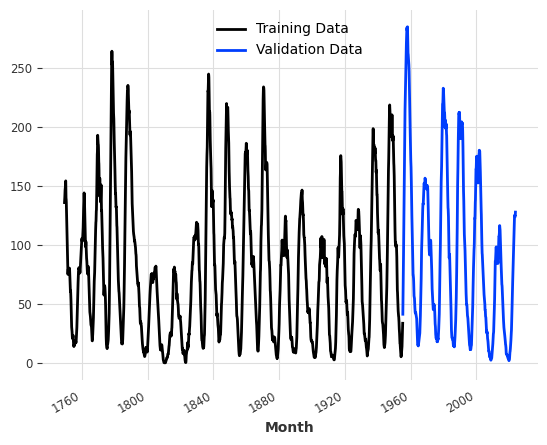

the 'monthly sunspots' dataset has 3293 data points


In [3]:
series = SunspotsDataset().load().astype(np.float32)

train, val = series.split_after(0.75)
train.plot(label = "Training Data")
val.plot(label='Validation Data')
plt.show()

scaler = Scaler()
train_scaled = scaler.fit_transform(train) #训练集
val_scaled = scaler.transform(val)       #测试集
series_scaled = scaler.transform(series) #全量数据

print("the 'monthly sunspots' dataset has {} data points".format(len(series_scaled)))

## 模型创建与训练

In [4]:
input_chunk_length = 20

In [5]:
model_name = "TCN_sun_one"
model = TCNModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=1,
    n_epochs=30,
    dropout=0,
    dilation_base=2,
    weight_norm=True,
    kernel_size=3,
    num_filters=6,
    nr_epochs_val_period=1,
    random_state=0,
    save_checkpoints=True,
    model_name=model_name,
    force_reset=True,
    **generate_torch_kwargs()
)

model.fit(
    series=train_scaled, 
    val_series=val_scaled, 
    verbose=True
)

Training: 0it [00:00, ?it/s]

TCNModel(output_chunk_shift=0, kernel_size=3, num_filters=6, num_layers=None, dilation_base=2, weight_norm=True, dropout=0, input_chunk_length=20, output_chunk_length=1, n_epochs=30, nr_epochs_val_period=1, random_state=0, save_checkpoints=True, model_name=TCN_sun_one, force_reset=True, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x0000017674541390>]})

In [6]:
best_model = TCNModel.load_from_checkpoint(
    model_name=model_name, best=True 
)

## 回测—模型对整个数据集的拟合

RMSE: 58.841866
MAE: 42.917446


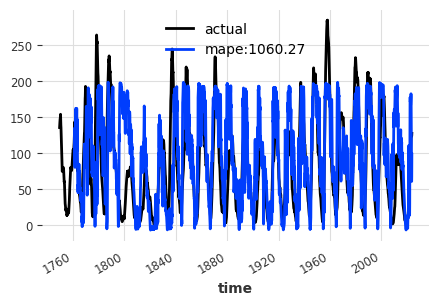

In [7]:
backtest = best_model.historical_forecasts(
    series=series_scaled,  # 输入整个序列
    forecast_horizon=120,  # 发出长度等于forecast_horizon的预测
    retrain=False,  # 是否重新训练模型
    verbose=True,  # 是否显示详细信息
)

plt.figure(figsize=(5, 3))
scaler.inverse_transform(series_scaled).plot(label="actual")  # 绘制实际值
scaler.inverse_transform(backtest).plot(label="mape:{:.2f}".format(mape(backtest, series_scaled)))  # 绘制Transformer模型预测值
plt.legend()  

# print("MAPE:", mape(backtest, series_scaled))  
print("RMSE:", rmse(scaler.inverse_transform(series_scaled),scaler.inverse_transform(backtest)))
print("MAE:", mae(scaler.inverse_transform(series_scaled),scaler.inverse_transform(backtest)))

## 模型评估

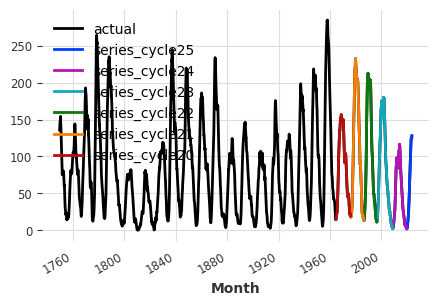

In [8]:
cycle20 = "19641001"         # "19641001" ,
cycle21 =  "19760301"        # "19760301",
cycle22 =  "19860901"        # "19860901",
cycle23 = "19960801"         #"19960801"
cycle24 = "20081201"         #"20081201"
cycle25 = "20191201"         #"20191201" 

before_series_cycle25, series_cycle25 = series_scaled.split_after(pd.Timestamp("20191101"))
before_series_cycle24, series_cycle24 = before_series_cycle25.split_after(pd.Timestamp("20081101"))
before_series_cycle23, series_cycle23 = before_series_cycle24.split_after(pd.Timestamp("19960701"))
before_series_cycle22, series_cycle22 = before_series_cycle23.split_after(pd.Timestamp("19860801"))
before_series_cycle21, series_cycle21 = before_series_cycle22.split_after(pd.Timestamp("19760201"))
before_series_cycle20, series_cycle20 = before_series_cycle21.split_after(pd.Timestamp("19640901"))

plt.figure(figsize=(5, 3))
scaler.inverse_transform(series_scaled).plot(label="actual")  # 绘制实际值
scaler.inverse_transform(series_cycle25).plot(label="series_cycle25")  # 绘制实际值
scaler.inverse_transform(series_cycle24).plot(label="series_cycle24")  # 绘制实际值
scaler.inverse_transform(series_cycle23).plot(label="series_cycle23")  # 绘制实际值
scaler.inverse_transform(series_cycle22).plot(label="series_cycle22")  # 绘制实际值
scaler.inverse_transform(series_cycle21).plot(label="series_cycle21")  # 绘制实际值
scaler.inverse_transform(series_cycle20).plot(label="series_cycle20")  # 绘制实际值
plt.legend() 

In [9]:
def eval_model(model,before_series,series,title):
    pred_series = model.predict(
        n=len(series),
        series = before_series
    )   
    
    series = scaler.inverse_transform(series)
    pred_series = scaler.inverse_transform(pred_series)
    print("两种数据的MAE：",mae(pred_series, series))
    print("两种数据的rmse:",rmse(series,pred_series))
    print("预测的长度：",len(series))
    print(series.time_index[0], pred_series.time_index[0])
    
    plt.figure(figsize=(5, 3))
    series.plot(label="Actual")
    pred_series.plot(label="Predict")
    plt.title(title)
    plt.legend()
    plt.show() 

两种数据的MAE： 41.625347
两种数据的rmse: 49.949512
预测的长度： 137
1964-10-01 00:00:00 1964-10-01 00:00:00


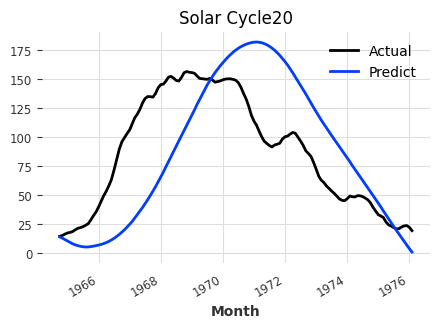

In [10]:
eval_model(best_model, before_series_cycle20,series_cycle20,"Solar Cycle20")

两种数据的MAE： 62.162727
两种数据的rmse: 72.85285
预测的长度： 126
1976-03-01 00:00:00 1976-03-01 00:00:00


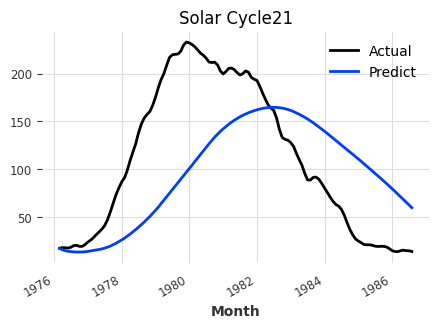

In [11]:
eval_model(best_model, before_series_cycle21,series_cycle21,"Solar Cycle21")

两种数据的MAE： 58.236973
两种数据的rmse: 65.86109
预测的长度： 119
1986-09-01 00:00:00 1986-09-01 00:00:00


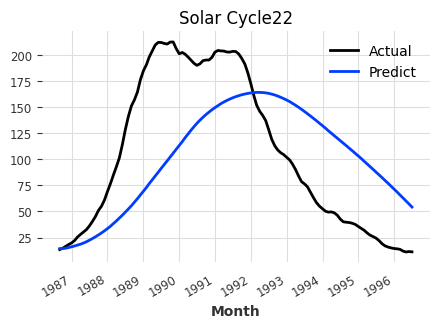

In [12]:
eval_model(best_model, before_series_cycle22,series_cycle22,"Solar Cycle22")

两种数据的MAE： 27.995817
两种数据的rmse: 34.597046
预测的长度： 148
1996-08-01 00:00:00 1996-08-01 00:00:00


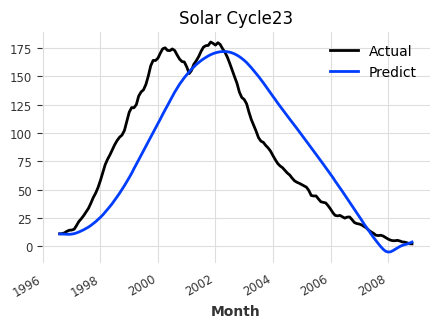

In [13]:
eval_model(best_model, before_series_cycle23,series_cycle23,"Solar Cycle23")

两种数据的MAE： 39.53812
两种数据的rmse: 49.80267
预测的长度： 132
2008-12-01 00:00:00 2008-12-01 00:00:00


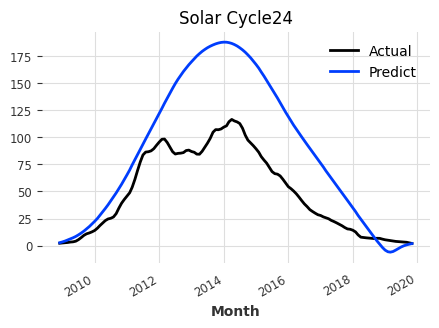

In [14]:
eval_model(best_model, before_series_cycle24,series_cycle24,"Solar Cycle24")

两种数据的MAE： 12.2728195
两种数据的rmse: 15.573511
预测的长度： 48
2019-12-01 00:00:00 2019-12-01 00:00:00


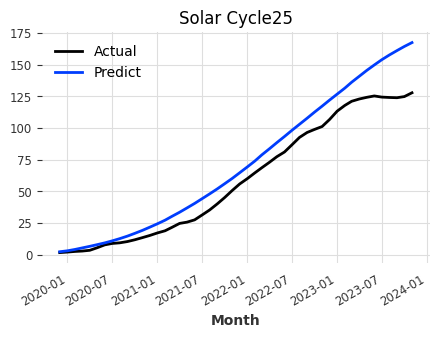

In [15]:
eval_model(best_model, before_series_cycle25,series_cycle25,"Solar Cycle25")

## 模型对各个活动周的拟合情况

In [16]:
def backtest(testing_model,cycle, series_cycle,title):
    backtest = testing_model.historical_forecasts(
        series=series_scaled,  # 输入整个序列
        start=pd.Timestamp(cycle),  # 开始时间
        forecast_horizon=1,  # 发出长度等于forecast_horizon的预测
        retrain=False,  # 是否重新训练模型
        verbose=True,  # 是否显示详细信息
    )
    backtest = backtest[0:len(series_cycle)]
    
    series_cycle = scaler.inverse_transform(series_cycle)
    backtest = scaler.inverse_transform(backtest)
    print(len(backtest),len(series_cycle))
    
    plt.figure(figsize=(5, 3))
    series_cycle.plot(label="Actual")  
    backtest.plot(label="Fitting")  
    plt.title(title)
    plt.legend()  
    
    print("MAE:", mae(backtest,series_cycle))
    print("RMSE:", rmse(backtest,series_cycle))
    print(series_cycle.time_index[0],backtest.time_index[0])
    
    return backtest

137 137
MAE: 1.4238318
RMSE: 1.7601632
1964-10-01 00:00:00 1964-10-01 00:00:00


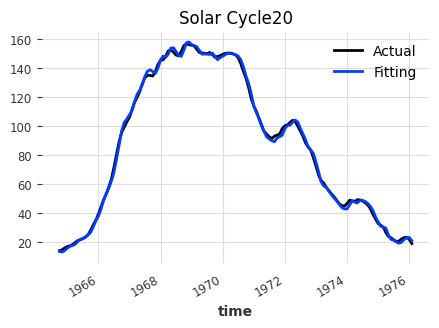

In [17]:
pred_series_cycle20 = backtest(best_model,cycle20,series_cycle20,"Solar Cycle20")  

126 126
MAE: 1.8858839
RMSE: 2.487002
1976-03-01 00:00:00 1976-03-01 00:00:00


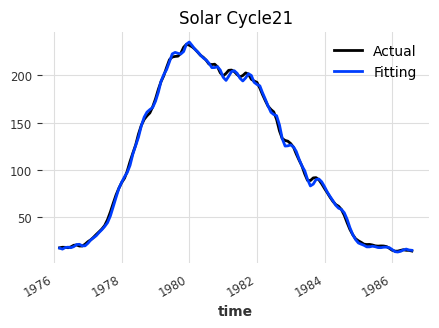

In [18]:
pred_series_cycle21 = backtest(best_model,cycle21,series_cycle21,"Solar Cycle21") 

119 119
MAE: 1.7093934
RMSE: 2.2763624
1986-09-01 00:00:00 1986-09-01 00:00:00


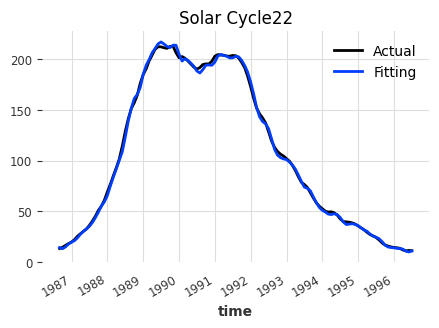

In [19]:
pred_series_cycle22 = backtest(best_model,cycle22, series_cycle22,"Solar Cycle22")

148 148
MAE: 1.4826883
RMSE: 1.9834237
1996-08-01 00:00:00 1996-08-01 00:00:00


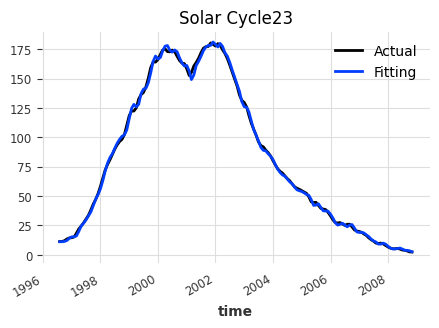

In [20]:
pred_series_cycle23 = backtest(best_model,cycle23,series_cycle23,"Solar Cycle23") 

132 132
MAE: 1.0973927
RMSE: 1.6072083
2008-12-01 00:00:00 2008-12-01 00:00:00


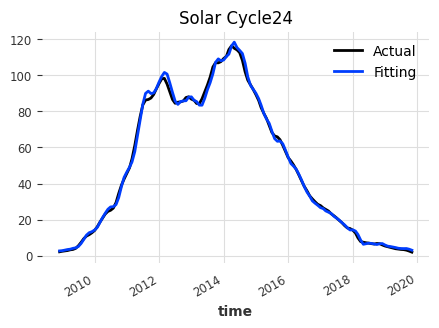

In [21]:
pred_series_cycle24 = backtest(best_model,cycle24,series_cycle24,"Solar Cycle24")

48 48
MAE: 1.0416851
RMSE: 1.2918218
2019-12-01 00:00:00 2019-12-01 00:00:00


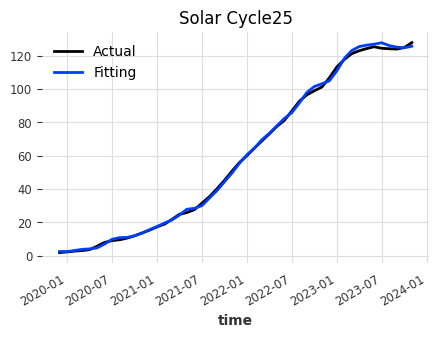

In [22]:
pred_series_cycle25 = backtest(best_model,cycle25, series_cycle25,"Solar Cycle25")

## 预测第25活动周

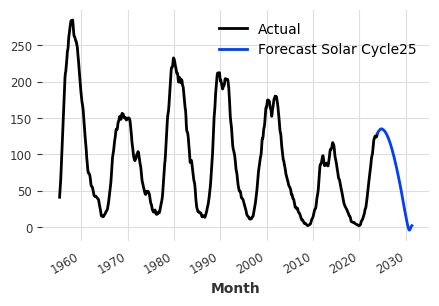

2023-12-01 00:00:00


In [23]:
def predict(model, n, series):
    # 对模型进行n个时间步长的预测
    pred_series = model.predict(n=n, series= series) #从最后一个训练集开始
    
    pred_series = scaler.inverse_transform(pred_series)
    series = scaler.inverse_transform(series)
    
    plt.figure(figsize=(5, 3))
    series.plot(label="Actual")
    pred_series.plot(label="Forecast Solar Cycle25")
    plt.legend()
    plt.show()
    
    return pred_series
    
pred_series_cycle = predict(best_model, 90, val_scaled)
print(pred_series_cycle.time_index[0])

In [24]:
darts_to_pd = TimeSeries.pd_dataframe(pred_series_cycle) 

max_date = darts_to_pd['Sunspots'].idxmax() #日期
print("活动高峰期出现在：",max_date)
max_value = darts_to_pd.loc[max_date]
print("活动峰值是：",max_value['Sunspots'])

min_date = darts_to_pd['Sunspots'].idxmin() #日期
print("活动结束于：",min_date)
min_value = darts_to_pd.loc[min_date]

right_series_cycle25, series_cycle26 = pred_series_cycle.split_after(pd.Timestamp("20301101")) #开始于2029.11，高峰期在203404，结束于203912

活动高峰期出现在： 2024-10-01 00:00:00
活动峰值是： 135.33604
活动结束于： 2030-11-01 00:00:00


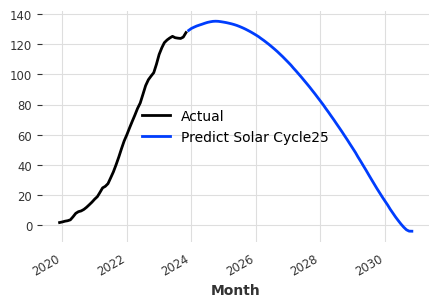

In [25]:
 plt.figure(figsize=(5, 3))
scaler.inverse_transform(series_cycle25).plot(label="Actual")
right_series_cycle25.plot(label="Predict Solar Cycle25")
plt.legend(loc='center')
plt.show()